In [1]:
import tensorflow as tf
import os
from machine_learning.neural_networks import tf_helpers as tfh
import pdb

from pynwb import NWBHDF5IO
import numpy as np
import os
import torch
import soundfile as sf
import scipy.stats
from process_nwb.resample import resample as resample_nwb
from scipy.stats.mstats import zscore
import samplerate

# Creating a list of dictionaries of:
# 
# `ecog_sequence`: ECoG data, clipped to token(-sequence) length
# `text_sequence`: the corresponding text token(-sequence)
# `audio_sequence`: the corresponding audio (MFCC) token sequence (gonna set to)
# `phoneme_sequence`: ditto for phonemes--with repeats
#
# Then saving them as tf_records

def transcription_to_array(trial_t0, trial_tF, onset_times, offset_times, transcription, max_length, sampling_rate):
    
    # if the transcription is missing (e.g. for covert trials)
    if transcription is None:
        return np.full(max_length, 'pau', dtype='<U5')

    # get just the parts of transcript relevant to this trial
    trial_inds = (onset_times >= trial_t0) * (offset_times < trial_tF)
    transcript = np.array(transcription.description.split(' '))[trial_inds]
    onset_times = np.array(onset_times[trial_inds])
    offset_times = np.array(offset_times[trial_inds])

    # vectorized indexing
    sample_times = trial_t0 + np.arange(max_length)/sampling_rate
    indices = (
        (sample_times[None, :] >= onset_times[:, None]) *
        (sample_times[None, :] < offset_times[:, None])
    )

    # no more than one phoneme should be on at once...
    try:
        # print('exactly one phoneme:', np.all(np.sum(indices, 0) == 1))
        assert np.all(np.sum(indices, 0) < 2)
    except:
        pdb.set_trace()

    # ...but there can be locations with *zero* phonemes; assume 'pau' here
    transcript = np.insert(transcript, 0, 'pau')
    indices = np.sum(indices*(np.arange(1, len(transcript))[:, None]), 0)

    return transcript[indices]

def sentence_tokenize(token_list): # token_type = word_sequence
    tokenized_sentence = [
                (token.lower() + '_').encode('utf-8') for token in token_list
            ]
    return tokenized_sentence

def write_to_Protobuf(path, example_dicts):
    '''
    Collect the relevant ECoG data and then write to disk as a (google)
        protocol buffer.
    '''
    writer = tf.io.TFRecordWriter(
        path)
    for example_dict in example_dicts:
        feature_example = tfh.make_feature_example(example_dict)
        writer.write(feature_example.SerializeToString())
            
# sorting function for latent representation filenames, NOT USED FOR THIS
# def custom_sort_key(filename):
#     num_part = int(filename.split('nwb_')[1].split('.wav.pt')[0])
#     return num_part

def resample(
    data, source_to_target_ratio, ZSCORE, resample_method='sinc_best',
    N_channels_max=128
):

    ######################
    # If downsampling by an integer, just anti-alias and subsample??
    ######################

    # 128 is the max for the underlying library
    N_channels_max = min(N_channels_max, 128)
    N_channels = data.shape[1]
    data_mat = None

    for i0 in np.arange(0, N_channels, N_channels_max):
        iF = np.min((i0+N_channels_max, N_channels))
        resampler = samplerate.Resampler(resample_method, channels=iF-i0)
        data_chunk = resampler.process(
            data[:, i0:iF], 1/source_to_target_ratio, end_of_input=True
        )
        data_mat = (
            data_chunk if data_mat is None else
            np.concatenate((data_mat, data_chunk), axis=1)
        )
    if ZSCORE:
        data_mat = zscore(data_mat)

    return data_mat

def downsample(data, rate_source, rate_target, ZSCORE=False):
    return downsample_NWB(data, rate_source, rate_target, ZSCORE=ZSCORE)
    # return resample(data, rate_source/rate_target, ZSCORE=ZSCORE)

def downsample_NWB(data, rate_source, rate_target, ZSCORE=False):
    '''
    Downsample data from rate_source to rate_target using process_NWB methods

    Input arguments:
    --------
    data:
        an ndarray of the data to downsample (Nsamples_source, Nchannels)
    source_rate:
        the sampling rate of the input data
    rate_target:
        the sampling rate of the output data

    Returns:
    --------
    X:
        An ndarray (Nsamples_source, Nchannels) of the downsampled data
    '''

    # Note: zero padding is done in resample
 
    # downsampling
    print("Downsampling signals to %s Hz; please wait..." % rate_target)
    Nsamples_source, Nchannels = data.shape
    ##############
    # 1e6 scaling helps with numerical accuracy
    # scale = 1e6
    scale = 1
    # Is this true??
    ##############
    
    # malloc
    Nsamples_target = int(np.ceil(Nsamples_source*rate_target/rate_source))
    X = np.zeros((Nsamples_target, Nchannels))

    # One channel at a time, to improve memory usage for long signals
    for ch in np.arange(Nchannels):
        X[:, ch] = resample_nwb(data[:, ch]*scale, rate_target, rate_source)
    X = X/scale

    if ZSCORE:
        X = scipy.stats.mstats.zscore(X)

    return X

# Removing bad electrodes

def elec_layout(grid_size, grid_step):
    layout = np.arange(np.prod(
        grid_size)-1, -1, -1).reshape(grid_size).T

    # now correct for subsampling the grid
    return layout[::grid_step, ::grid_step]
    
def good_electrodes(grid_size, bad_electrodes):
    '''
    NB!!! bad_electrodes are 1-indexed, good_electrodes are zero-indexed!!

    Since this is a set, it contains no order information.  The canonical
    ordering is established with good_channels, since after all the data
    size is (... x Nchannels),  not (... x Nelectrodes).
    '''

    # bad_electrodes = [int(e.strip()) for e in bad_electrodes]
    return (
        set(range(np.prod(grid_size))) -
        set(np.array(bad_electrodes)-1)
    )
    
def bipolar_to_elec_map(layout):
    # print('WARNING!!!!  MAKING UP bipolar_to_elec_map!!!')
    elec_map = []
    # layout = self.elec_layout  # for short
    for i in range(layout.shape[0]):
        for j in range(layout.shape[1]):
            if j < layout.shape[1]-1:
                elec_map.append((layout[i, j], layout[i, j+1]))
            if i < layout.shape[0]-1:
                elec_map.append((layout[i, j], layout[i+1, j]))
    return np.array(elec_map)
    
def good_channels(elec_layout, bipolar_to_elec_map, good_electrodes):
    '''
    Pseudo-channels, constructed (on the fly) from the physical electrodes.
    For now at least, we won't USE_FIELD_POTENTIALS if we want to
    REFERENCE_BIPOLAR.

    NB!!: The *order* of these channels matters--it determines the order of
    the input data, and therefore is required by the functions that plot
    electrode_contributions in plotters.py! And the order of these channels
    will be determined by the *elec_layout*.
    '''

    # NB: this means that the electrodes are *not* in numerical order ('e1'
    #  does not correspond to the 0th entry in all_electrodes): as you can
    #  check, flattening the elec_layout does not yield an ordered list.
    all_electrodes = elec_layout.flatten().tolist()

    # if self.USE_FIELD_POTENTIALS:
    #     M = len(all_electrodes)
    #     return (
    #         [e for e in all_electrodes if e in self.good_electrodes] +
    #         [e+M for e in all_electrodes if e in self.good_electrodes]
    #     )
    # elif self.REFERENCE_BIPOLAR:
    return [
        ch for ch, elec_pair in enumerate(bipolar_to_elec_map)
        if all([e in good_electrodes for e in elec_pair])
    ]
    # else:
    #     return [e for e in all_electrodes if e in self.good_electrodes]

2023-12-13 12:21:23.559942: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-13 12:21:23.559969: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-13 12:21:23.560991: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-13 12:21:23.566026: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-13 12:21:24.046762: W tensorflow/compiler/tf2

In [4]:
import matplotlib.pyplot as plt

all_example_dict = []
            
blocks = [4, 41, 57, 61, 66, 69, 73, 77, 83, 87] # [3,4,6,8,10,12,14,15,19,23,28,30,38,40,42,46,57,61,72] # change this for what tf_record you're making
_bad_electrodes = [1,2,63,64,65,127,143,193,194,195,196,235,239,243,252,254,255,256]
# bad_electrodes = [i - 1 for i in bad_electrodes]
# good_electrodes = [x for x in list(np.arange(256)) if x not in bad_electrodes]

grid_size = np.array([16, 16])
grid_step = 1

_good_electrodes = good_electrodes(grid_size, _bad_electrodes)
_elec_layout = elec_layout(grid_size, grid_step)
_bipolar_to_elec_map = bipolar_to_elec_map(_elec_layout)

# print(_bad_electrodes)
# print(_good_electrodes)

_good_channels = good_channels(_elec_layout, _bipolar_to_elec_map, _good_electrodes)

# print(len(_good_channels))
for block in blocks:

    tfrecord_path = f'/home/bayuan/Documents/fall23/ecog2vec/wav2vec_tfrecords/ecog2txt/word_sequence/tf_records_orig/EFC401_B{block}.tfrecord'

    nwb_filepath = folder_path = f"/NWB/EFC401/EFC401_B{block}.nwb"
    io = NWBHDF5IO(nwb_filepath, load_namespaces=True, mode='r')
    nwbfile = io.read()
    
    high_gamma = nwbfile.processing['ecephys'].\
                    data_interfaces['LFP'].\
                    electrical_series['high gamma (bipolar)'].\
                    data[:,_good_channels]
                    
    # high_gamma = downsample(high_gamma, 400, 200, ZSCORE=True)
    
    nwb_sr = nwbfile.processing['ecephys'].\
                    data_interfaces['LFP'].\
                    electrical_series['high gamma (bipolar)'].\
                    rate
    
    phoneme_transcriptions = nwbfile.processing['behavior'].data_interfaces['BehavioralEpochs'].interval_series #['phoneme transcription'].timestamps[:]

    token_type = 'word_sequence'

    max_seconds_dict = {
        'phoneme': 0.2,
        'word': 1.0,
        'word_sequence': 6.25,
        'word_piece_sequence': 6.25,
        'phoneme_sequence': 6.25,
        'trial': 6.25
    }

    if 'phoneme transcription' in phoneme_transcriptions:
        print(f'Phoneme transcription for block {block} exists.')
        phoneme_transcript = phoneme_transcriptions['phoneme transcription']
        phoneme_onset_times = phoneme_transcript.timestamps[
            phoneme_transcript.data[()] == 1]
        phoneme_offset_times = phoneme_transcript.timestamps[
            phoneme_transcript.data[()] == -1]
    else:
        phoneme_transcript = None
        phoneme_onset_times = None
        phoneme_offset_times = None

    example_dicts = []

    makin_sr = 200
    
    high_gamma = downsample(high_gamma, nwb_sr, makin_sr, ZSCORE=True)
    
    starts = list(nwbfile.trials[:]['start_time']) # * nwb_sr)
    stops = list(nwbfile.trials[:]['stop_time']) # * nwb_sr)
    
    print(starts[0], stops[0])

    for index, trial in enumerate(nwbfile.trials):
        t0 = float(trial.iloc[0].start_time)
        tF = float(trial.iloc[0].stop_time)
    
        i0 = np.rint(makin_sr*t0).astype(int)
        iF = np.rint(makin_sr*tF).astype(int)
        
        # ECOG (C) SEQUENCE
        c = high_gamma[i0:iF,:]
    
        print(c.shape)
        nsamples = c.shape[0]
        
        # TEXT SEQUENCE
        speech_string = trial['transcription'].values[0]
        text_sequence = sentence_tokenize(speech_string.split(' ')) # , 'text_sequence')
        
        # AUDIO SEQUENCE    
        audio_sequence = []
        
        # PHONEME SEQUENCE
        
        M = iF - i0
        
        max_seconds = max_seconds_dict.get(token_type) # , 0.2) # i don't think this 0.2 default is necessary for the scope of this
        max_samples = int(np.floor(makin_sr*max_seconds))
        max_length = min(M, max_samples)
        
        phoneme_array = transcription_to_array(
                        t0, tF, phoneme_onset_times, phoneme_offset_times,
                        phoneme_transcript, max_length, makin_sr
                    )
        
        phoneme_sequence = [ph.encode('utf-8') for ph in phoneme_array]
        
        if len(phoneme_sequence) != nsamples:
            if len(phoneme_sequence) > nsamples:
                phoneme_sequence = [phoneme_sequence[i] for i in range(nsamples)]
            else:
                for i in range(nsamples - len(phoneme_sequence)):
                    phoneme_sequence.append(phoneme_sequence[len(phoneme_sequence) - 1])
        
        print('\n------------------------')
        print(f'For sentence {index}: ')
        print(c[0:5,0:5])
        print(f'Latent representation shape: {c.shape} (should be [samples, nchannel])')
        print(text_sequence)
        print(f'Audio sequence: {audio_sequence}')
        print(f'Length of phoneme sequence: {len(phoneme_sequence)}')
        print(phoneme_sequence)
        print('------------------------\n')
        
        example_dicts.append({'ecog_sequence': c, 'text_sequence': text_sequence, 'audio_sequence': [], 'phoneme_sequence': phoneme_sequence,})
        
        
        # break
    
    # break
        
    all_example_dict.extend(example_dicts)
    print(len(example_dicts))
    print(len(all_example_dict))
    write_to_Protobuf(tfrecord_path, example_dicts)

print(len(all_example_dict))


/home/bayuan/anaconda3/envs/ecog2txt/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.6.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/bayuan/anaconda3/envs/ecog2txt/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.3.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Phoneme transcription for block 4 exists.
Downsampling signals to 200 Hz; please wait...


KeyboardInterrupt: 

In [2]:
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, filtfilt, hilbert
from scipy.fft import fft, ifft

all_example_dict = []
            
blocks = [4, 41, 57, 61, 66, 69, 73, 77, 83, 87] # [3,4,6,8,10,12,14,15,19,23,28,30,38,40,42,46,57,61,72] # change this for what tf_record you're making
_bad_electrodes = [1,2,63,64,65,127,143,193,194,195,196,235,239,243,252,254,255,256]
# bad_electrodes = [i - 1 for i in bad_electrodes]
# good_electrodes = [x for x in list(np.arange(256)) if x not in bad_electrodes]

grid_size = np.array([16, 16])
grid_step = 1

_good_electrodes = good_electrodes(grid_size, _bad_electrodes)
_elec_layout = elec_layout(grid_size, grid_step)
_bipolar_to_elec_map = bipolar_to_elec_map(_elec_layout)

# print(_bad_electrodes)
# print(_good_electrodes)

_good_channels = good_channels(_elec_layout, _bipolar_to_elec_map, _good_electrodes)

# print(len(_good_channels))
for block in blocks:

    tfrecord_path = f'/home/bayuan/Documents/fall23/ecog2vec/wav2vec_tfrecords/ecog2txt/word_sequence/tf_records_orig/EFC401_B{block}.tfrecord'

    nwb_filepath = folder_path = f"/NWB/EFC401/EFC401_B{block}.nwb"
    io = NWBHDF5IO(nwb_filepath, load_namespaces=True, mode='r')
    nwbfile = io.read()
    
    electrode_table = nwbfile.acquisition['ElectricalSeries'].\
                                        electrodes.table[:]

    indices = np.where(np.logical_or(electrode_table['group_name'] == 
                                        'L256GridElectrode electrodes', 
                                        electrode_table['group_name'] == 
                                        'R256GridElectrode electrodes'))[0]

    raw_data = nwbfile.acquisition['ElectricalSeries'].\
                                    data[:,indices]
                                    
    raw_data = raw_data[:,sorted(list(_good_electrodes))]
                    
    # high_gamma = downsample(high_gamma, 400, 200, ZSCORE=True)
    
    nwb_sr = nwbfile.acquisition['ElectricalSeries'].\
                                rate
    
    w_l = 70 / (nwb_sr / 2) # Normalize the frequency
    w_h = 200 / (nwb_sr / 2)
    b, a = butter(5, [w_l,w_h], 'band')
    
    for ch in range(raw_data.shape[1]):
        raw_data[:,ch] = filtfilt(b, 
                                a, 
                                raw_data[:,ch])
        
        #analytic amp
        raw_data[:,ch] = np.abs(hilbert(raw_data[:,ch]))
        
    high_gamma = raw_data
    
    phoneme_transcriptions = nwbfile.processing['behavior'].data_interfaces['BehavioralEpochs'].interval_series #['phoneme transcription'].timestamps[:]

    token_type = 'word_sequence'

    max_seconds_dict = {
        'phoneme': 0.2,
        'word': 1.0,
        'word_sequence': 6.25,
        'word_piece_sequence': 6.25,
        'phoneme_sequence': 6.25,
        'trial': 6.25
    }

    if 'phoneme transcription' in phoneme_transcriptions:
        print(f'Phoneme transcription for block {block} exists.')
        phoneme_transcript = phoneme_transcriptions['phoneme transcription']
        phoneme_onset_times = phoneme_transcript.timestamps[
            phoneme_transcript.data[()] == 1]
        phoneme_offset_times = phoneme_transcript.timestamps[
            phoneme_transcript.data[()] == -1]
    else:
        phoneme_transcript = None
        phoneme_onset_times = None
        phoneme_offset_times = None

    example_dicts = []

    makin_sr = 101.7 # 200
    
    
    high_gamma = downsample(high_gamma, nwb_sr, makin_sr, ZSCORE=True)
    
    # starts = list(nwbfile.trials[:]['start_time']) # * nwb_sr)
    # stops = list(nwbfile.trials[:]['stop_time']) # * nwb_sr)
    
    # print(starts[0], stops[0])

    for index, trial in enumerate(nwbfile.trials):
        t0 = float(trial.iloc[0].start_time)
        tF = float(trial.iloc[0].stop_time)
    
        i0 = np.rint(makin_sr*t0).astype(int)
        iF = np.rint(makin_sr*tF).astype(int)
        
        # ECOG (C) SEQUENCE
        c = high_gamma[i0:iF,:]
        # print(c.shape)
        # plt.plot(c[:,0])
        # break
    
        print(c.shape)
        nsamples = c.shape[0]
        
        # TEXT SEQUENCE
        speech_string = trial['transcription'].values[0]
        text_sequence = sentence_tokenize(speech_string.split(' ')) # , 'text_sequence')
        
        # AUDIO SEQUENCE    
        audio_sequence = []
        
        # PHONEME SEQUENCE
        
        M = iF - i0
        
        max_seconds = max_seconds_dict.get(token_type) # , 0.2) # i don't think this 0.2 default is necessary for the scope of this
        max_samples = int(np.floor(makin_sr*max_seconds))
        max_length = min(M, max_samples)
        
        phoneme_array = transcription_to_array(
                        t0, tF, phoneme_onset_times, phoneme_offset_times,
                        phoneme_transcript, max_length, makin_sr
                    )
        
        phoneme_sequence = [ph.encode('utf-8') for ph in phoneme_array]
        
        if len(phoneme_sequence) != nsamples:
            if len(phoneme_sequence) > nsamples:
                phoneme_sequence = [phoneme_sequence[i] for i in range(nsamples)]
            else:
                for i in range(nsamples - len(phoneme_sequence)):
                    phoneme_sequence.append(phoneme_sequence[len(phoneme_sequence) - 1])
        
        print('\n------------------------')
        print(f'For sentence {index}: ')
        print(c[0:5,0:5])
        print(f'Latent representation shape: {c.shape} (should be [samples, nchannel])')
        print(text_sequence)
        print(f'Audio sequence: {audio_sequence}')
        print(f'Length of phoneme sequence: {len(phoneme_sequence)}')
        print(phoneme_sequence)
        print('------------------------\n')
        
        example_dicts.append({'ecog_sequence': c, 'text_sequence': text_sequence, 'audio_sequence': [], 'phoneme_sequence': phoneme_sequence,})
        
        
        # break
    
    # break
        
    all_example_dict.extend(example_dicts)
    print(len(example_dicts))
    print(len(all_example_dict))
    write_to_Protobuf(tfrecord_path, example_dicts)

print(len(all_example_dict))


/home/bayuan/anaconda3/envs/ecog2txt/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.6.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/bayuan/anaconda3/envs/ecog2txt/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.3.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Phoneme transcription for block 4 exists.
Downsampling signals to 101.7 Hz; please wait...
(393, 238)

------------------------
For sentence 0: 
[[-0.23082108 -0.77454707 -0.57507145  0.56119122 -0.0647177 ]
 [-0.09974324 -0.4370973  -0.25009408 -0.60282595 -0.28071189]
 [ 0.78493215 -0.51412813  0.78570224 -1.39784517  1.84943851]
 [-0.58173371 -1.09639552  1.07155096 -0.27646253 -0.31193996]
 [-0.39600046 -0.24909088 -0.02199422 -0.84436174  0.30471657]]
Latent representation shape: (393, 238) (should be [samples, nchannel])
[b'mum_', b'strongly_', b'dislikes_', b'appetizers_']
Audio sequence: []
Length of phoneme sequence: 393
[b'm', b'm', b'm', b'm', b'm', b'm', b'm', b'm', b'm', b'm', b'm', b'm', b'm', b'm', b'm', b'm', b'm', b'm', b'm', b'm', b'm', b'm', b'm', b'm', b'm', b'm', b'm', b'm', b'm', b'ah', b'ah', b'ah', b'ah', b'ah', b'ah', b'ah', b'ah', b'ah', b'ah', b'ah', b'ah', b'ah', b'ah', b'ah', b'ah', b'ah', b'ah', b'ah', b'ah', b'ah', b'ah', b'ah', b'ah', b'ah', b'ah', b'ah'

/home/bayuan/anaconda3/envs/ecog2txt/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.6.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/bayuan/anaconda3/envs/ecog2txt/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.3.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Phoneme transcription for block 41 exists.
Downsampling signals to 101.7 Hz; please wait...
(225, 238)

------------------------
For sentence 0: 
[[-0.59988332 -0.86857292  1.10699258  0.00466836  1.07256686]
 [-0.88592928 -0.91101715 -0.16372257 -0.71708734  0.71920474]
 [ 0.06345834 -1.30137511  0.60833226 -0.90712267  0.41619771]
 [ 0.02382005  0.19845715 -0.42729414 -1.13772849  0.11375984]
 [-0.85872381 -0.18088217 -0.62140466 -0.37202021 -0.8097998 ]]
Latent representation shape: (225, 238) (should be [samples, nchannel])
[b'those_', b'musicians_', b'harmonize_', b'marvellously_']
Audio sequence: []
Length of phoneme sequence: 225
[b'dh', b'dh', b'dh', b'ow', b'ow', b'ow', b'ow', b'ow', b'ow', b'ow', b'ow', b'ow', b'ow', b'z', b'z', b'z', b'z', b'z', b'z', b'z', b'z', b'z', b'z', b'z', b'z', b'm', b'm', b'm', b'm', b'm', b'y', b'y', b'y', b'y', b'y', b'uw', b'uw', b'uw', b'uw', b'uw', b'z', b'z', b'z', b'z', b'z', b'z', b'z', b'ih', b'ih', b'ih', b'ih', b'ih', b'ih', b'ih', b'sh'

/home/bayuan/anaconda3/envs/ecog2txt/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.6.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/bayuan/anaconda3/envs/ecog2txt/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.3.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Phoneme transcription for block 57 exists.
Downsampling signals to 101.7 Hz; please wait...
(274, 238)

------------------------
For sentence 0: 
[[-0.18297751 -0.34369968 -0.7783201  -0.42296859  1.99873586]
 [-0.23997586 -0.59429324 -0.61109403 -0.33131393  1.38569202]
 [-0.07092982 -0.627937   -1.0026689   0.42590069 -0.00425623]
 [-0.03570231 -1.04662951 -0.49892134 -0.01861634 -0.29417167]
 [ 2.50970432  0.03112829  0.11919944  0.22788425 -1.02746148]]
Latent representation shape: (274, 238) (should be [samples, nchannel])
[b'young_', b'people_', b'participate_', b'in_', b'athletic_', b'activities_']
Audio sequence: []
Length of phoneme sequence: 274
[b'y', b'y', b'y', b'y', b'y', b'y', b'y', b'y', b'y', b'ah', b'ah', b'ah', b'ah', b'ah', b'ah', b'ah', b'ah', b'ah', b'ah', b'ah', b'ah', b'ah', b'ah', b'ng', b'ng', b'ng', b'ng', b'ng', b'ng', b'ng', b'ng', b'ng', b'ng', b'ng', b'p', b'p', b'p', b'p', b'p', b'p', b'iy', b'iy', b'iy', b'iy', b'iy', b'iy', b'iy', b'iy', b'p', b'p', b'

/home/bayuan/anaconda3/envs/ecog2txt/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.6.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/bayuan/anaconda3/envs/ecog2txt/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.3.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Phoneme transcription for block 61 exists.
Downsampling signals to 101.7 Hz; please wait...
(262, 238)

------------------------
For sentence 0: 
[[-0.51435752 -0.83184439 -0.94017345  1.43500045  0.02049764]
 [-0.64952555  0.52026621 -0.70294285 -0.13297443 -0.87216977]
 [-1.09253145  0.21815906  0.60205522 -0.36016398 -1.16244788]
 [ 1.04031532 -0.02042297  0.9493454   1.60289114  0.34614144]
 [-0.4311803   0.41648753 -0.58927152  0.87504061 -0.20073336]]
Latent representation shape: (262, 238) (should be [samples, nchannel])
[b'help_', b'greg_', b'to_', b'pick_', b'a_', b'peck_', b'of_', b'potatoes_']
Audio sequence: []
Length of phoneme sequence: 262
[b'hh', b'hh', b'hh', b'hh', b'hh', b'hh', b'eh', b'eh', b'l', b'l', b'l', b'l', b'l', b'l', b'l', b'l', b'l', b'l', b'p', b'p', b'p', b'p', b'g', b'g', b'g', b'g', b'g', b'g', b'g', b'g', b'g', b'g', b'g', b'r', b'r', b'r', b'r', b'r', b'r', b'r', b'r', b'r', b'r', b'eh', b'eh', b'eh', b'eh', b'eh', b'eh', b'eh', b'eh', b'eh', b'eh', 

/home/bayuan/anaconda3/envs/ecog2txt/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.6.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/bayuan/anaconda3/envs/ecog2txt/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.3.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Phoneme transcription for block 66 exists.
Downsampling signals to 101.7 Hz; please wait...
(178, 238)

------------------------
For sentence 0: 
[[ 0.63238545 -0.79821122  0.79160724  1.33728103 -0.67316316]
 [-0.91487089 -1.16867859  0.37160799 -0.0837872  -0.53438975]
 [-0.02439126  0.1726143   0.16727378 -0.88515629 -1.30358228]
 [-0.0199748   1.75531212 -0.80359065  0.93826665  0.00224292]
 [-0.39218332  0.77941605 -0.54823878 -0.2890833  -0.08267406]]
Latent representation shape: (178, 238) (should be [samples, nchannel])
[b"don't_", b'do_', b'charlie_', b'dirty_', b'dishes_']
Audio sequence: []
Length of phoneme sequence: 178
[b'd', b'd', b'd', b'd', b'ow', b'ow', b'ow', b'ow', b'ow', b'ow', b'ow', b'ow', b'ow', b'ow', b'ow', b'ow', b'ow', b'ow', b'n', b'n', b'n', b'n', b'n', b'n', b'n', b'n', b'n', b't', b't', b'd', b'd', b'd', b'uw', b'uw', b'uw', b'uw', b'uw', b'uw', b'uw', b'uw', b'uw', b'uw', b'uw', b'ch', b'ch', b'ch', b'ch', b'ch', b'ch', b'ch', b'ch', b'ch', b'ch', b'ch'

/home/bayuan/anaconda3/envs/ecog2txt/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.6.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/bayuan/anaconda3/envs/ecog2txt/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.3.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Phoneme transcription for block 69 exists.
Downsampling signals to 101.7 Hz; please wait...
(398, 238)

------------------------
For sentence 0: 
[[-1.23209567 -1.03066432 -0.35064098 -1.34227674  0.67878021]
 [-0.23248773 -1.2170671   0.41961164 -0.8339465  -0.06939739]
 [-0.73444719 -1.39125103  0.10242602 -0.6498577  -0.84369046]
 [ 0.35243264 -0.96650071 -0.10761902 -0.46026814 -1.59295896]
 [ 0.94830074 -0.58977798  0.65639814  0.23558709 -0.08609881]]
Latent representation shape: (398, 238) (should be [samples, nchannel])
[b'she_', b'is_', b'thinner_', b'than_', b'i_', b'am_']
Audio sequence: []
Length of phoneme sequence: 398
[b'sh', b'sh', b'iy', b'iy', b'ih', b'z', b'z', b'pau', b'pau', b'pau', b'pau', b'pau', b'pau', b'pau', b'pau', b'pau', b'pau', b'pau', b'pau', b'pau', b'pau', b'pau', b'pau', b'th', b'ih', b'ih', b'n', b'n', b'n', b'n', b'n', b'n', b'n', b'n', b'n', b'n', b'n', b'n', b'n', b'n', b'n', b'n', b'n', b'n', b'n', b'n', b'n', b'n', b'n', b'n', b'n', b'n', b'n', 

/home/bayuan/anaconda3/envs/ecog2txt/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.6.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/bayuan/anaconda3/envs/ecog2txt/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.3.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Phoneme transcription for block 73 exists.
Downsampling signals to 101.7 Hz; please wait...
(409, 238)

------------------------
For sentence 0: 
[[-1.26069359 -0.60853041 -0.69320389 -0.45929337 -0.70920753]
 [-0.21002145  0.89949164  0.00336787 -1.19497481  0.85424554]
 [-1.37658716  0.71188416  1.02702935  0.06052984 -0.69976921]
 [-0.62961683  1.17148807  0.12330095 -0.04688665  0.04016731]
 [ 0.06437827 -0.11395767 -1.27270581 -0.91221404  0.86975486]]
Latent representation shape: (409, 238) (should be [samples, nchannel])
[b'he_', b'will_', b'allow_', b'a_', b'rare_', b'lie_']
Audio sequence: []
Length of phoneme sequence: 409
[b'hh', b'hh', b'hh', b'iy', b'pau', b'pau', b'pau', b'pau', b'pau', b'pau', b'pau', b'pau', b'pau', b'pau', b'pau', b'pau', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', 

/home/bayuan/anaconda3/envs/ecog2txt/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.6.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/bayuan/anaconda3/envs/ecog2txt/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.3.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Phoneme transcription for block 77 exists.
Downsampling signals to 101.7 Hz; please wait...
(272, 238)

------------------------
For sentence 0: 
[[-0.30679356  1.33771831  0.95544206 -0.897877   -1.24462914]
 [ 0.53750078  1.6678346   0.26715593  0.19030424 -0.21770848]
 [ 1.40081098  0.77695368 -0.0114218  -0.64302125  1.19651145]
 [-0.34853212 -1.1145742   1.29029328  0.62761035 -0.59415437]
 [ 1.56198789 -0.94604032  3.60226309 -0.83407955 -1.03849815]]
Latent representation shape: (272, 238) (should be [samples, nchannel])
[b'those_', b'thieves_', b'stole_', b'thirty_', b'jewels_']
Audio sequence: []
Length of phoneme sequence: 272
[b'dh', b'dh', b'dh', b'dh', b'dh', b'dh', b'dh', b'dh', b'dh', b'dh', b'dh', b'dh', b'dh', b'dh', b'dh', b'dh', b'dh', b'dh', b'dh', b'dh', b'dh', b'dh', b'dh', b'dh', b'dh', b'dh', b'dh', b'dh', b'dh', b'dh', b'dh', b'dh', b'dh', b'dh', b'dh', b'dh', b'dh', b'dh', b'dh', b'dh', b'dh', b'dh', b'dh', b'dh', b'dh', b'dh', b'dh', b'dh', b'dh', b'dh', b'dh

/home/bayuan/anaconda3/envs/ecog2txt/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.6.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/bayuan/anaconda3/envs/ecog2txt/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.3.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Phoneme transcription for block 83 exists.
Downsampling signals to 101.7 Hz; please wait...
(464, 238)

------------------------
For sentence 0: 
[[-0.44444775 -0.75204088  0.40676706 -0.09797904  0.25673306]
 [ 1.34383921  0.23156603  0.86261626 -0.61499033  1.03530661]
 [ 0.34622163 -0.56690113  0.22437845 -0.25599778  0.06130978]
 [-0.31124057 -0.0834713  -0.60745343  0.01680473  1.20544672]
 [-1.17730665 -0.78126259 -0.3371399   0.43346523 -0.54947126]]
Latent representation shape: (464, 238) (should be [samples, nchannel])
[b'she_', b'wore_', b'warm_', b'fleecy_', b'woolen_', b'overalls_']
Audio sequence: []
Length of phoneme sequence: 464
[b'sh', b'sh', b'iy', b'iy', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', b'w', 

/home/bayuan/anaconda3/envs/ecog2txt/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.6.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/bayuan/anaconda3/envs/ecog2txt/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.3.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Phoneme transcription for block 87 exists.
Downsampling signals to 101.7 Hz; please wait...
(386, 238)

------------------------
For sentence 0: 
[[-0.81042517 -0.29091409  0.35570279 -0.88705815 -0.76148923]
 [-0.10520762 -1.18607681 -0.81039791 -1.50729287  0.24288456]
 [-0.08669957  1.2893463  -0.7104882  -0.65988674 -0.1062103 ]
 [-0.75485565 -0.21272154 -0.96087052 -0.67763327 -0.81043925]
 [ 0.3832633  -1.06041248  0.24380025 -1.52097775 -1.32473976]]
Latent representation shape: (386, 238) (should be [samples, nchannel])
[b'alfalfa_', b'is_', b'healthy_', b'for_', b'you_']
Audio sequence: []
Length of phoneme sequence: 386
[b'ae', b'ae', b'l', b'l', b'f', b'f', b'ae', b'l', b'l', b'f', b'ax', b'ax', b'pau', b'pau', b'pau', b'pau', b'pau', b'pau', b'pau', b'pau', b'pau', b'pau', b'pau', b'ih', b'z', b'z', b'z', b'z', b'z', b'z', b'z', b'z', b'z', b'z', b'z', b'z', b'z', b'z', b'z', b'z', b'z', b'z', b'z', b'z', b'z', b'z', b'z', b'z', b'z', b'z', b'z', b'z', b'z', b'z', b'z', b'z

(336, 238)


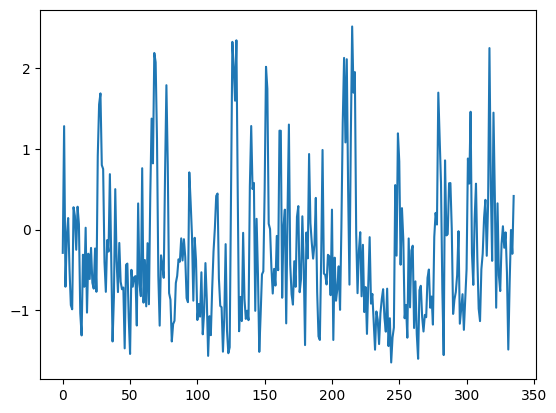

In [7]:
print(c.shape)
plt.plot(c[:,0])

# import soundfile as sf
# import matplotlib.pyplot as plt
# wave, sr = sf.read('/home/bayuan/Documents/fall23/ecog2vec/wav2vec_inputs/raw_hg_nonspeakonly/EFC401_B4.nwb_0.wav')

# print(wave.T[1,:][0:20])
# plt.plot(wave.T[1,:][0:300])



Checking data-passing... filtering... etc

In [24]:
from pynwb import NWBHDF5IO
import numpy as np
import soundfile as sf
import os
from scipy.fft import fft, ifft, fftfreq
from scipy.signal import butter, lfilter, filtfilt

high_gamma_min = 70
high_gamma_max = 200

path = '/NWB/EFC401/EFC401_B4.nwb'

io = NWBHDF5IO(path, load_namespaces=True, mode='r')
nwbfile = io.read()

electrode_table = nwbfile.acquisition['ElectricalSeries'].\
                                      electrodes.table[:]

indices = np.where(np.logical_or(electrode_table['group_name'] == 
                                    'L256GridElectrode electrodes', 
                                    electrode_table['group_name'] == 
                                    'R256GridElectrode electrodes'))[0]

nwbfile_electrodes = nwbfile.acquisition['ElectricalSeries'].\
                                data[:,indices]
                                
original = nwbfile_electrodes

high_gamma = nwbfile.processing['ecephys'].\
                    data_interfaces['LFP'].\
                    electrical_series['high gamma (bipolar)'].\
                    data[()]

sr = nwbfile.acquisition['ElectricalSeries'].\
                              rate
                    
w_l = high_gamma_min / (sr / 2) # Normalize the frequency
w_h = high_gamma_max / (sr / 2)
b, a = butter(5, [w_l,w_h], 'band')

for ch in range(nwbfile_electrodes.shape[1]):
    nwbfile_electrodes[:,ch] = filtfilt(b, 
                                        a, 
                                        nwbfile_electrodes[:,ch])
    
filtered = nwbfile_electrodes*5

/home/bayuan/anaconda3/envs/ecog2txt/lib/python3.8/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.6.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/bayuan/anaconda3/envs/ecog2txt/lib/python3.8/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.3.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


[-3.6064709e-08  3.4921172e-07  7.1264924e-07  1.0442828e-06
  1.3327233e-06  1.5648840e-06  1.7269826e-06  1.8066642e-06
  1.7957542e-06  1.6929371e-06]


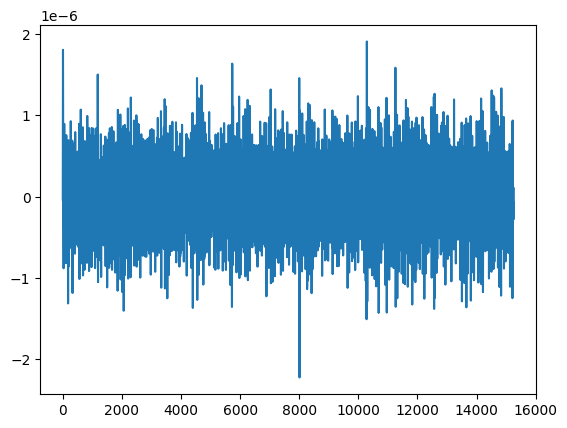

In [25]:
import matplotlib.pyplot as plt
print(original[0:10,0])
plt.plot(original[0:int(5*sr),0])

[0.01566422 0.0153849  0.01498984 0.01448885 0.01389436 0.01322094
 0.01248475 0.01170301 0.01089338 0.01007342]


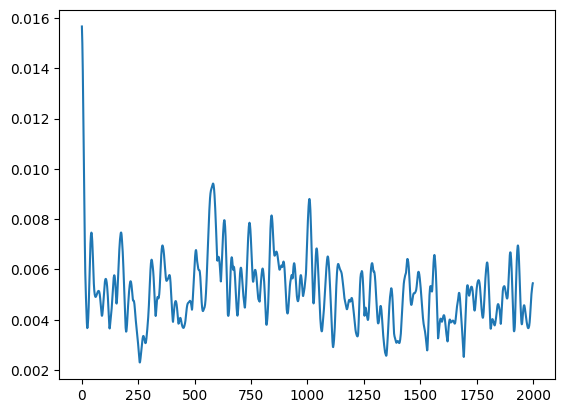

In [22]:
print(high_gamma[0:10,0])
plt.plot(high_gamma[0:5*400,0])

[-1.8032354e-07  1.7460586e-06  3.5632461e-06  5.2214141e-06
  6.6636167e-06  7.8244202e-06  8.6349137e-06  9.0333206e-06
  8.9787709e-06  8.4646854e-06]


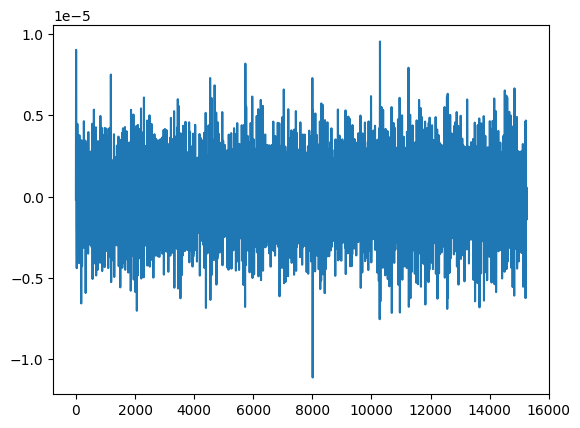

In [26]:
print(filtered[0:10,0])
plt.plot(filtered[0:int(5*sr),0])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


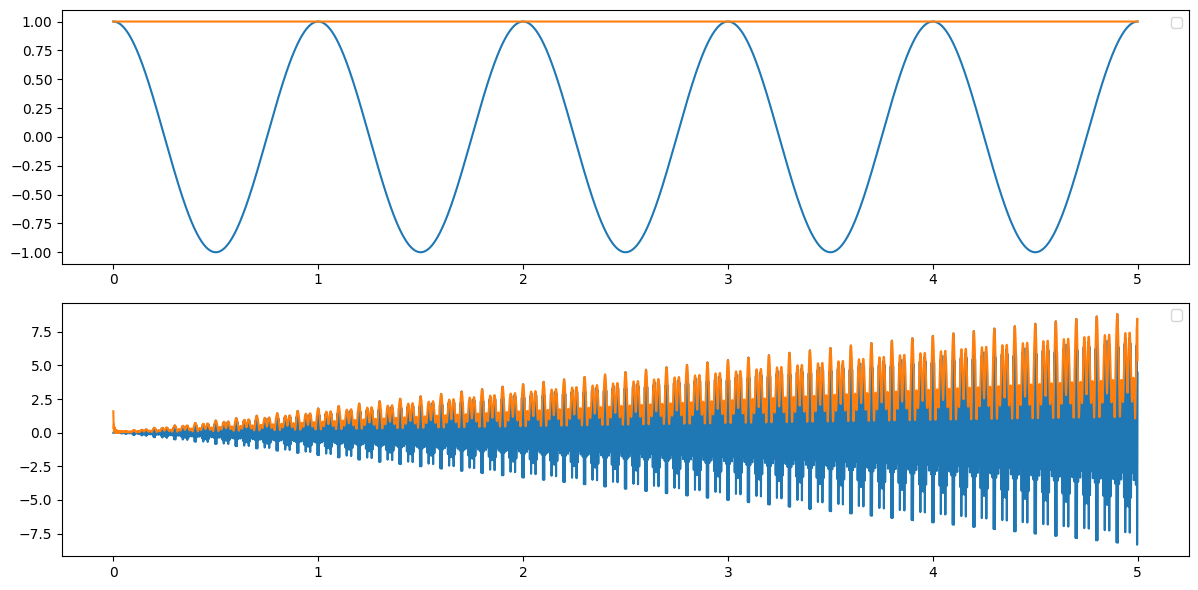

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert

# Function to generate a perfect cosine wave
def generate_cosine_wave(frequency, duration, sampling_rate):
    t = np.arange(0, duration, 1/sampling_rate)
    signal = np.cos(2 * np.pi * frequency * t)
    return t, signal

# Function to generate a signal with multiple cosine waves and varying amplitudes
def generate_complex_signal(frequencies, duration, sampling_rate):
    t = np.arange(0, duration, 1/sampling_rate)
    signal = np.zeros_like(t)

    for i, freq in enumerate(frequencies):
        amplitude = 0.6 * t  # Linearly varying amplitude with time
        signal += amplitude * np.cos(2 * np.pi * freq * t)

    return t, signal

# Function to calculate analytic amplitude using Hilbert transform
def calculate_analytic_amplitude(signal):
    analytic_signal = hilbert(signal)
    amplitude_envelope = np.abs(analytic_signal)
    return amplitude_envelope

# Parameters
frequency = 1.0  # Frequency of the perfect cosine wave
duration = 5.0   # Duration of the signals in seconds
sampling_rate = 1000  # Sampling rate in Hz

# Generate perfect cosine wave
t_cosine, signal_cosine = generate_cosine_wave(frequency, duration, sampling_rate)

# Generate complex signal with multiple cosine waves and varying amplitudes
frequencies = [140.0, 170.0, 190.0]  # Example frequencies for the complex signal
t_complex, signal_complex = generate_complex_signal(frequencies, duration, sampling_rate)

# Calculate analytic amplitude
amplitude_envelope_cosine = calculate_analytic_amplitude(signal_cosine)
amplitude_envelope_complex = calculate_analytic_amplitude(signal_complex)

# Plotting
plt.figure(figsize=(12, 6))

# Plotting the perfect cosine wave and its analytic amplitude
plt.subplot(2, 1, 1)
plt.plot(t_cosine, signal_cosine)
plt.plot(t_cosine, amplitude_envelope_cosine)
# plt.title('Perfect Cosine Wave and Analytic Amplitude')
# plt.xlabel('Time (s)')
# plt.ylabel('Amplitude')
plt.legend()

# Plotting the complex signal and its analytic amplitude
plt.subplot(2, 1, 2)
plt.plot(t_complex, signal_complex)
plt.plot(t_complex, amplitude_envelope_complex)
# plt.title('Complex Signal with Varying Amplitudes and Analytic Amplitude')
# plt.xlabel('Time (s)')
# plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.show()
